<a href="https://colab.research.google.com/github/holmes27/Emotion-Recognition/blob/main/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install -q keras

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import keras
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
path='/content/drive/MyDrive/deap'

In [ ]:
file_name='path/s01.mat'

In [ ]:
data_dict=loadmat('/content/drive/MyDrive/deap/s01.mat')

In [ ]:
labels=data_dict['labels']
data=data_dict['data']
labels.shape

(40, 4)

In [ ]:
data.shape

(40, 40, 8064)

The DEAP dataset contains data collected
using 40 music videos, 10 in each quadrant. The EEG signal was recorded using 32 active
AgCl electrodes with the Biosemi ActiveTwo system.

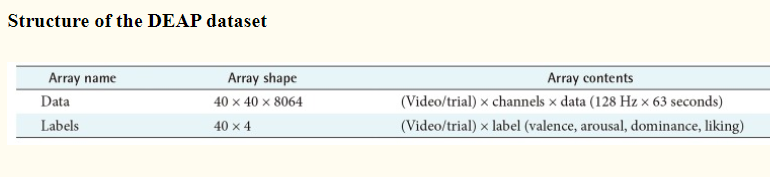

# Segmentation of data

**Segmenting the data**

In [ ]:
sample_rate = 128
p1 = np.array(data_dict['data'])[:,:,:sample_rate*60]
print(len(p1),type(p1))
print(len(p1[0]),type(p1[0]))
print(len(p1[0][0])/sample_rate,type(p1[0][0]))
secs = len(p1[0][0])/sample_rate
num_segments = secs/4
p1 = np.dsplit(p1,num_segments)
print(len(p1),type(p1))
print(len(p1[0]),type(p1[0]))
print(len(p1[0][0]),type(p1[0][0]))
print(len(p1[0][0][0])/sample_rate,type(p1[0][0][0]))
overlapping_segments = []
for i in range(len(p1)-3):
    seg = np.concatenate((p1[i],p1[i+1],p1[i+2]),axis = 2)
    overlapping_segments.append(seg)
print(len(overlapping_segments))
print(len(overlapping_segments[0]))
print(len(overlapping_segments[0][0]))
print(len(overlapping_segments[0][0][0])/sample_rate)
print(overlapping_segments[0][0][0][0])

40 <class 'numpy.ndarray'>
40 <class 'numpy.ndarray'>
60.0 <class 'numpy.ndarray'>
15 <class 'list'>
40 <class 'numpy.ndarray'>
40 <class 'numpy.ndarray'>
4.0 <class 'numpy.ndarray'>
12
40
40
12.0
0.948231680995192


# Binary Classification 

We need to perform Binary Classification for valence and arousal
The values equal to or more than 5 are considered 1 and rest 0


In [ ]:
valence=labels[:,[0]]
arousal=labels[:,[1]]

df = pd.DataFrame(valence, columns =['Valence'])

df['category']=df['Valence']>=5
df.head()

,Valence,category
0,7.71,True
1,8.10,True
2,8.58,True
3,4.94,False
4,6.96,True


In [ ]:

df['category']=df['category'].astype(int)
df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)
df_train.dropna(axis=1, inplace=True) # drop the empty feature in column 2
df_valid.dropna(axis=1, inplace=True)

X_train = df_train.drop('category', axis=1)
X_valid = df_valid.drop('category', axis=1)
y_train = df_train['category']
y_valid = df_valid['category']

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[1]),
    layers.Dense(4, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Best Validation Loss: 0.0733
Best Validation Accuracy: 1.0000


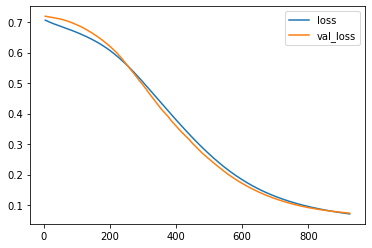

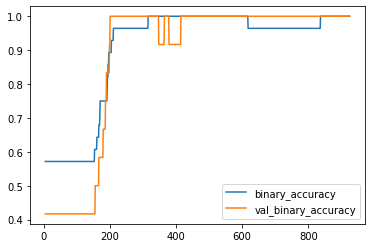

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))